In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import glob
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

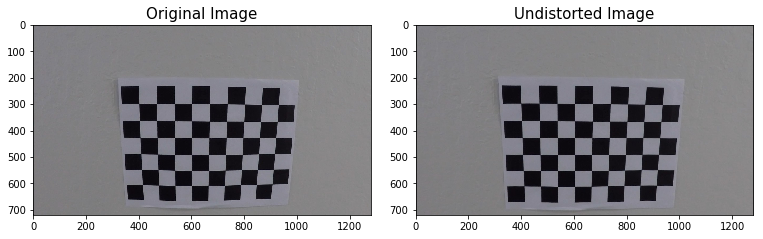

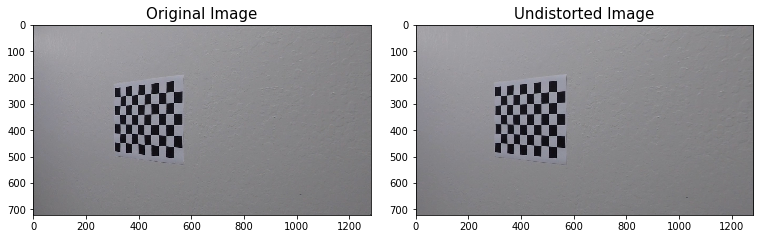

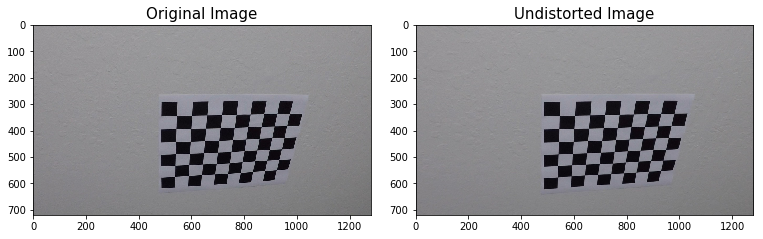

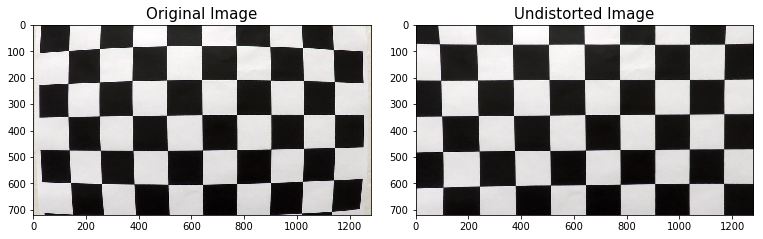

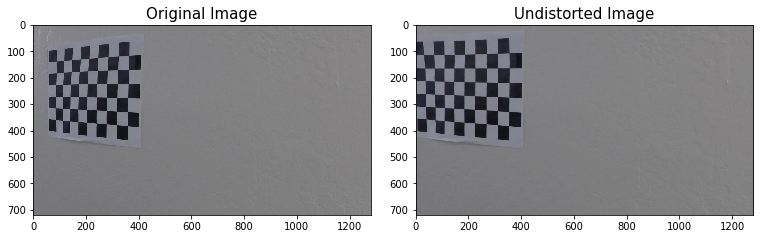

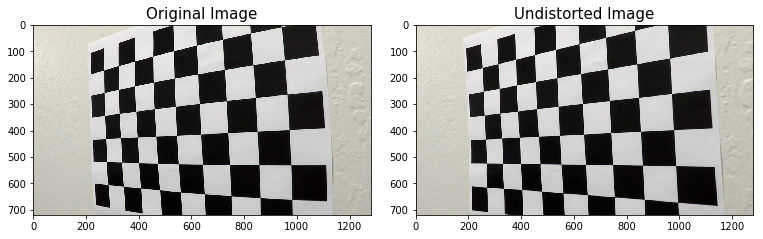

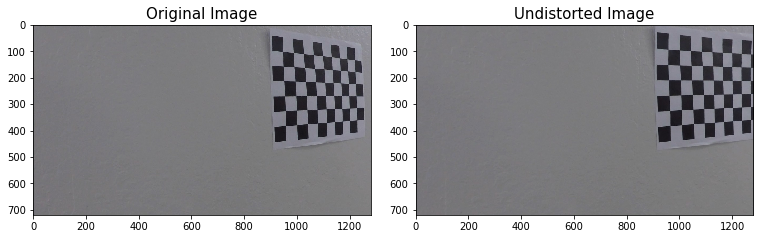

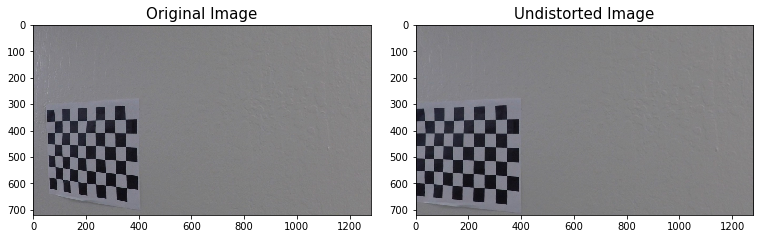

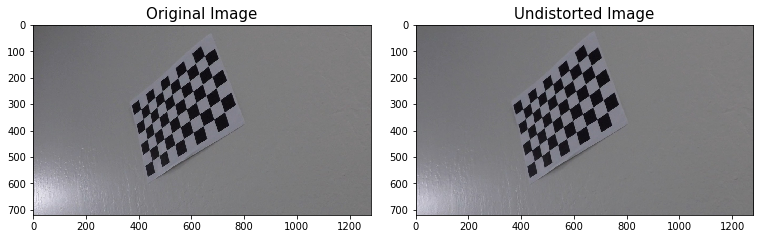

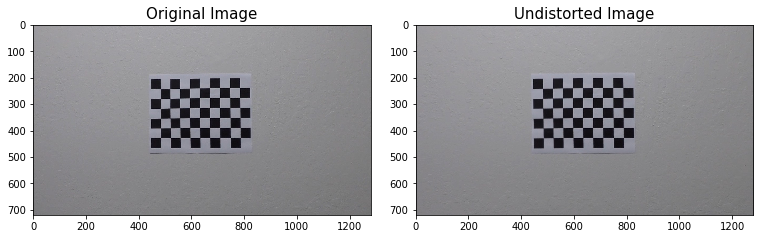

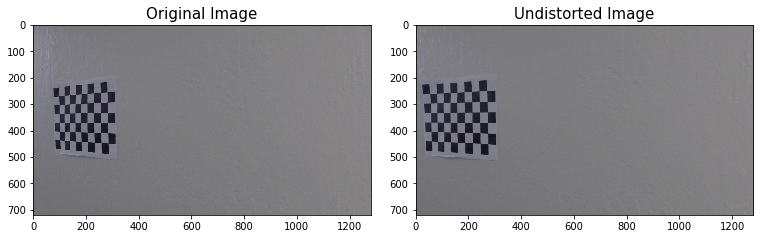

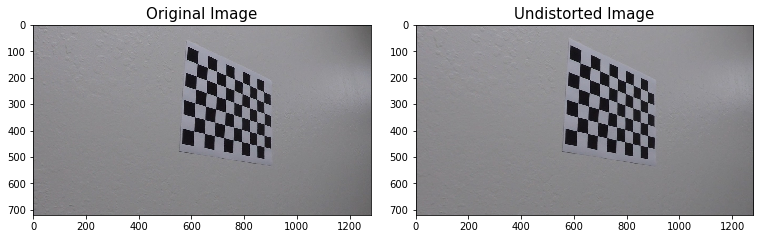

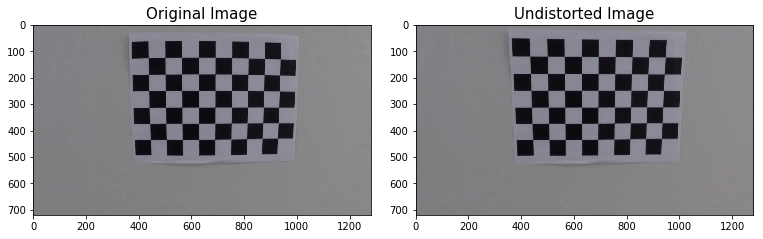

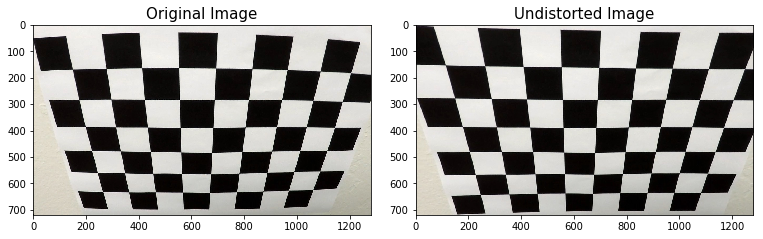

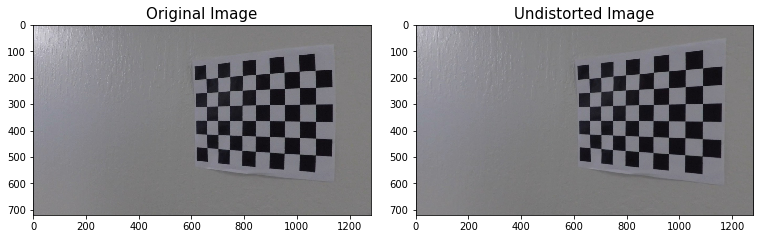

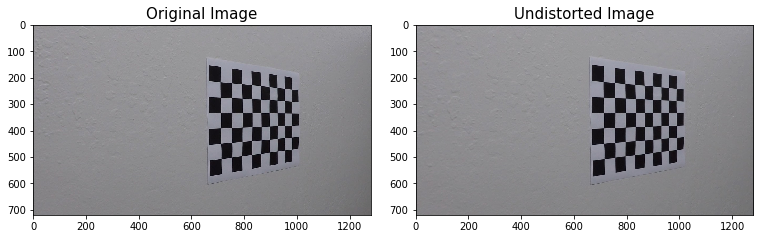

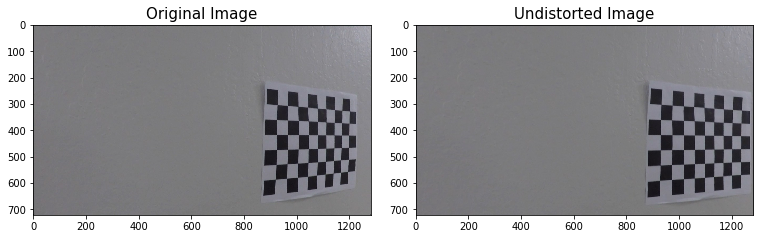

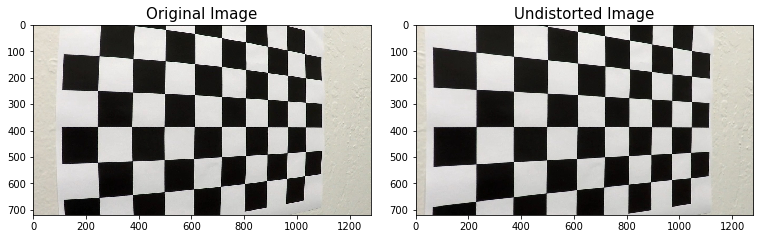

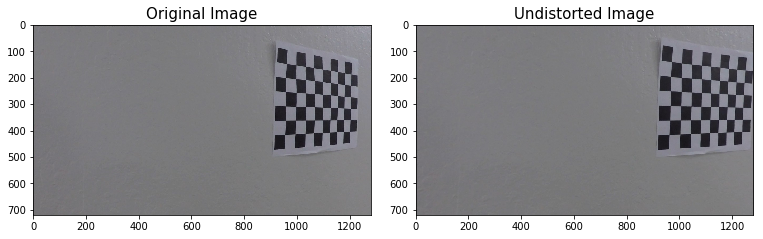

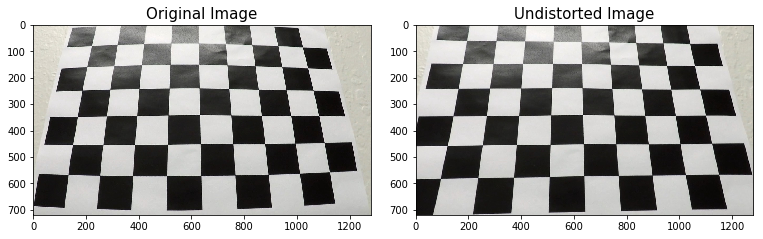

In [2]:
from Calibration import Calibration

nx = 9
ny = 6
image_path = glob.glob('camera_cal/calibration*.jpg')
calibration = Calibration(nx=nx, ny=ny, image_paths=image_path)

for fname in image_path:
    _ = calibration.plot_images(fname)

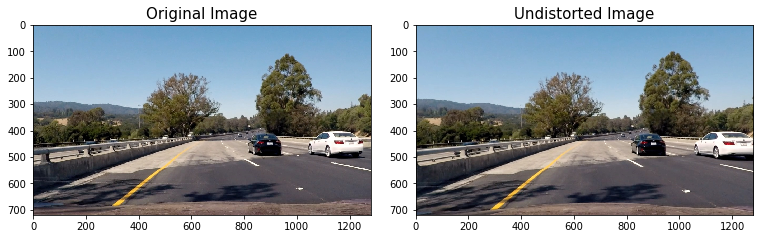

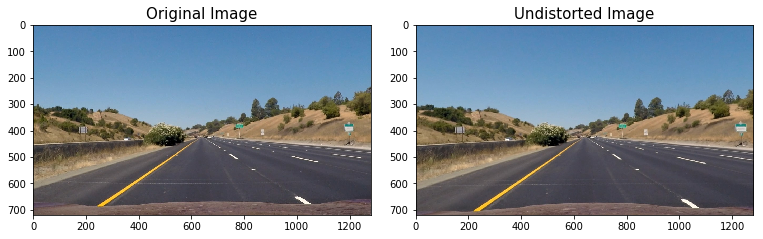

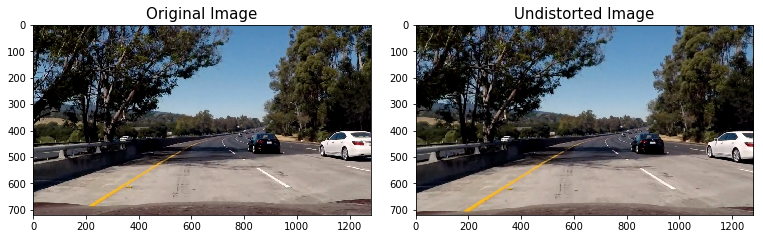

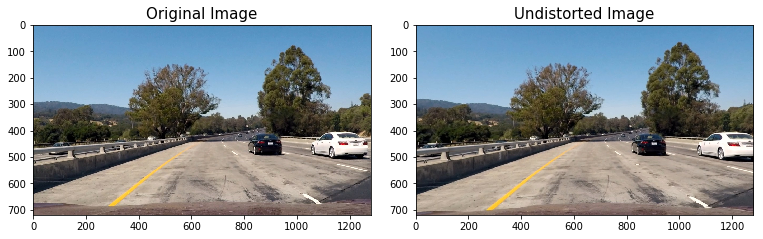

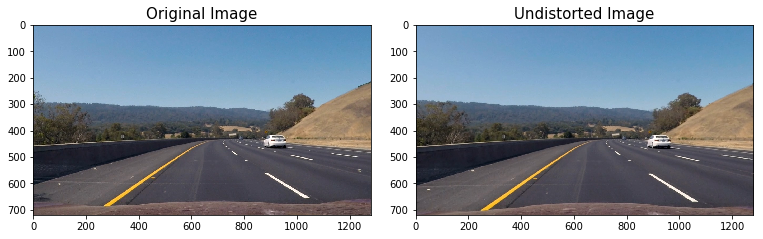

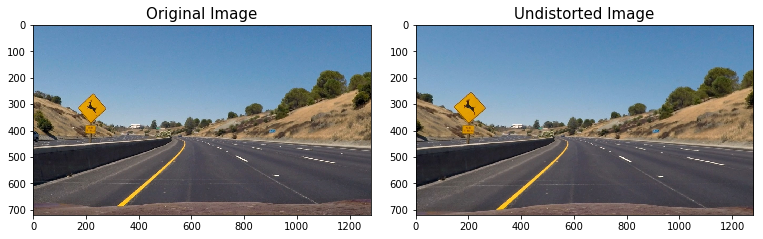

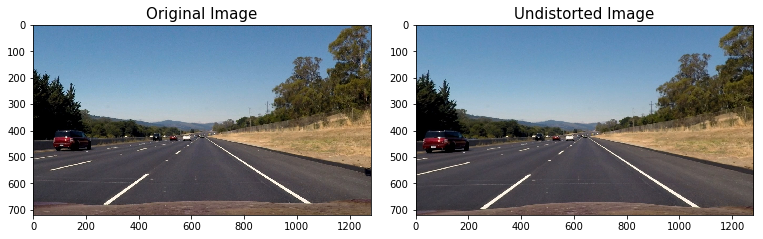

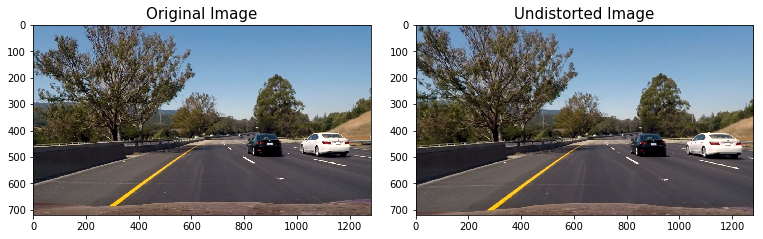

In [3]:
undist_images = []
images = glob.glob('./test_images/*.jpg')
for fname in images:
    undist_img = calibration.plot_images(fname)
    undist_images.append(undist_img)

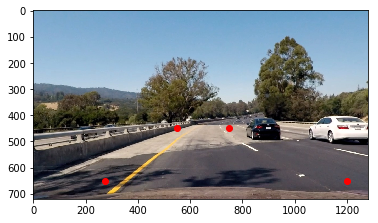

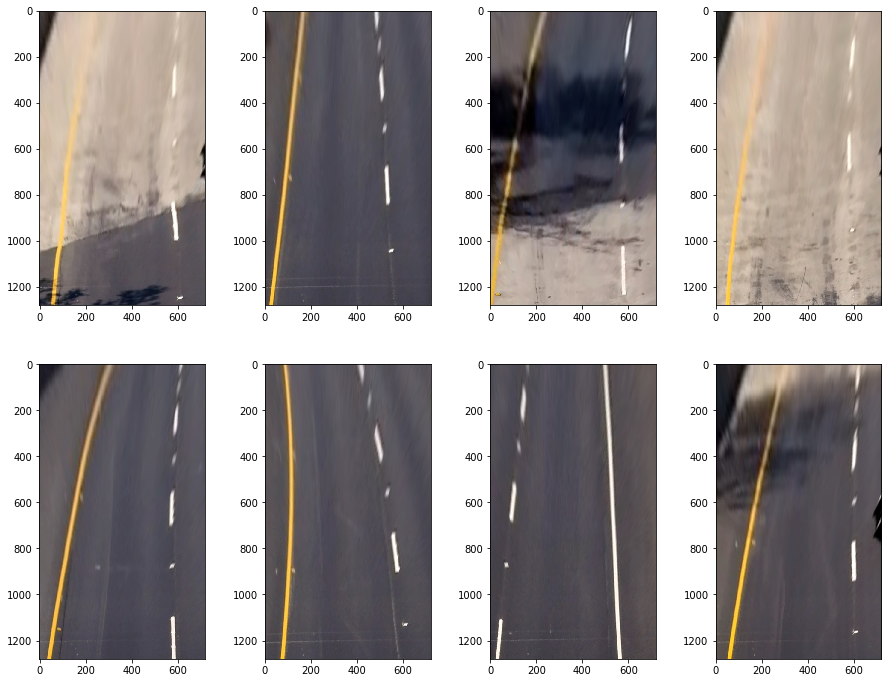

In [4]:
from Warp import PerspectiveTransform
xlen, ylen, _ = undist_images[0].shape
src_pts = np.array([[275, 650], 
                    [1200,650], 
                    [750, 450], 
                    [550, 450]], np.float32)

dts_pts = np.array([[0, ylen],
                    [xlen, ylen],
                    [xlen, 0], 
                    [0, 0]], np.float32)

for point in src_pts:
    plt.imshow(undist_images[0])
    plt.plot(point[0], point[1], 'o', color='r')
plt.show()

perspective = PerspectiveTransform(src_pts, dts_pts)
warp_images = [perspective.warp(img) for img in undist_images]

fig = plt.figure(figsize=(12,18))
for i, img in enumerate(warp_images):
    ax = plt.subplot(2,4,i+1)
    ax.imshow(img, cmap='gray')    
    plt.subplots_adjust(left=0., right=1, top=0.5, bottom=0.)


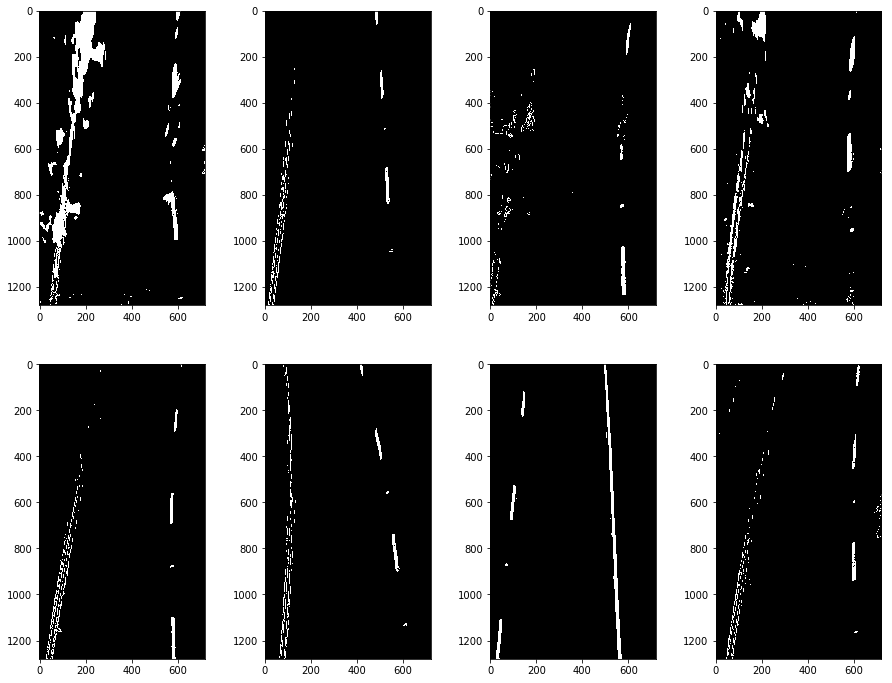

In [5]:
from Thresholding import *

binary_images = [combined_thresholds(img) for img in warp_images]

fig = plt.figure(figsize=(12,18))
for i, img in enumerate(binary_images):
    ax = plt.subplot(2,4,i+1)
    ax.imshow(img, cmap='gray')    
    plt.subplots_adjust(left=0.0, right=1, top=0.5, bottom=0.0)

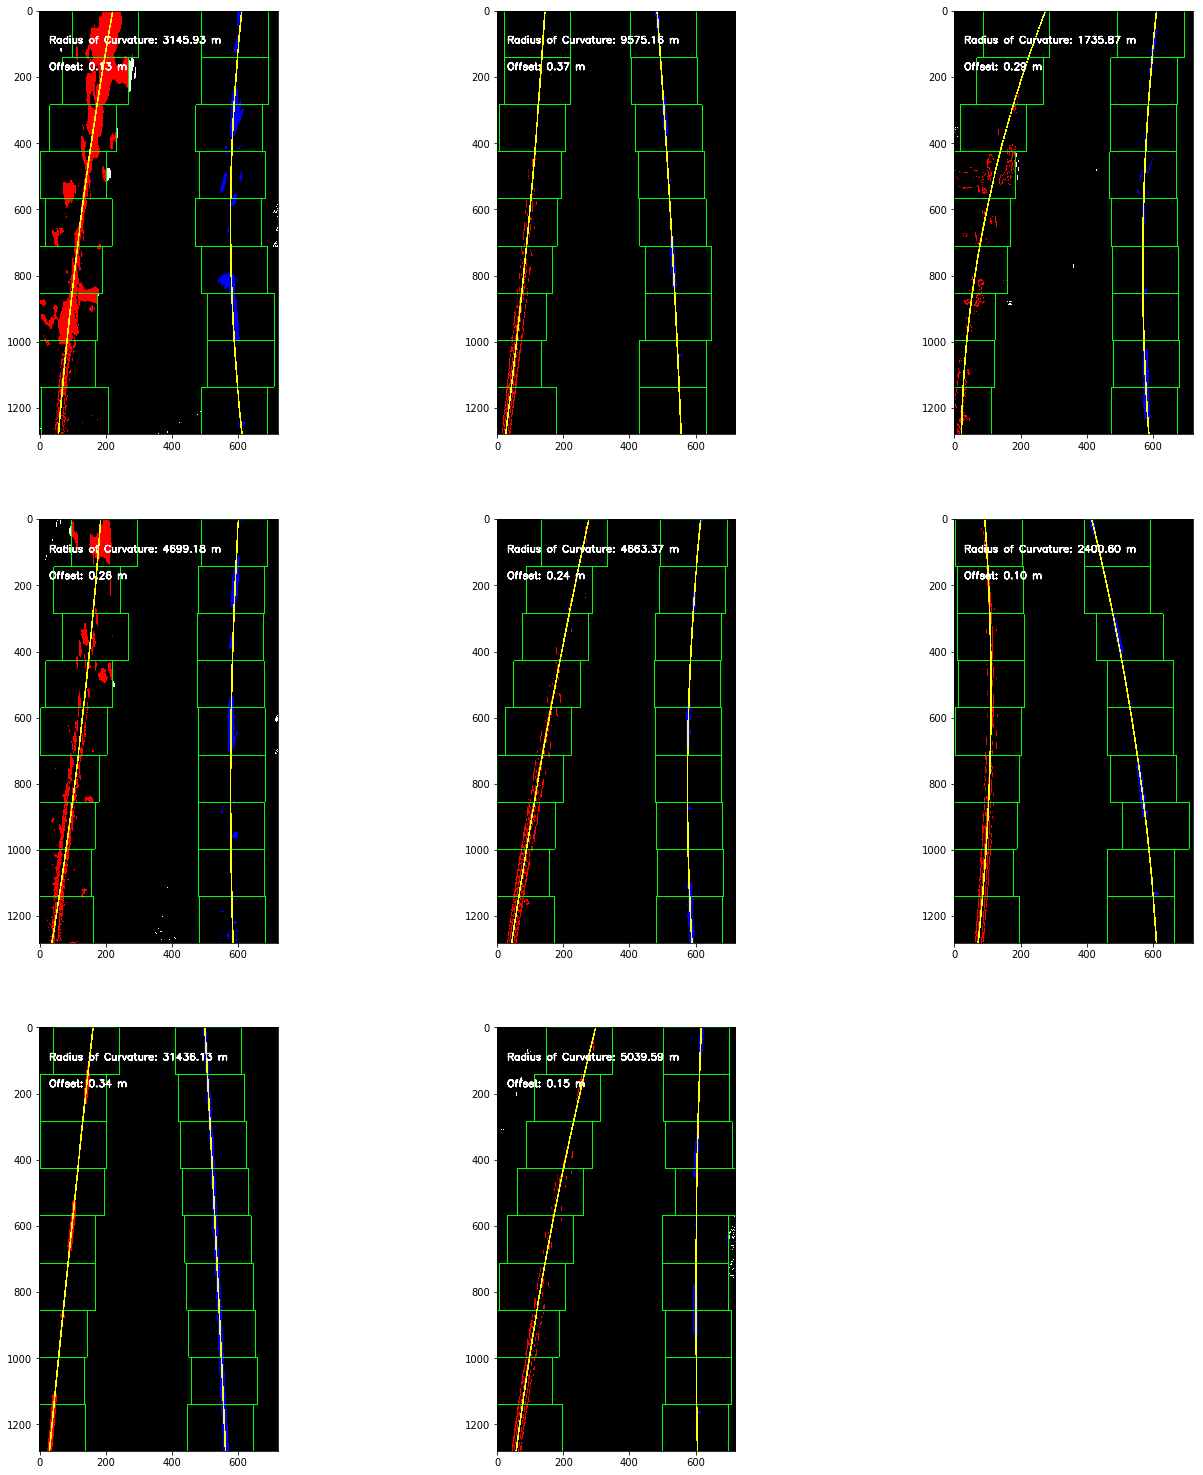

In [6]:
from LaneDetectors import *
lane_detector = LaneDetector(primary = True, n_windows = 9, margin = 100)
lane_images = [lane_detector.detect_lanes(image, img_only=True) for image in binary_images]

fig = plt.figure(figsize=(18,40))
for i, img in enumerate(lane_images):
    ax = plt.subplot(3, 3,i+1)
    ax.imshow(img, cmap='gray')    
    plt.subplots_adjust(left=0.0, right=1, top=0.5, bottom=0.0)



In [7]:
lane_detector = LaneDetector(primary = False, n_windows = 10, margin = 100)

def lane_overlay(binary_image, left_fit, right_fit):
    """ Get the lane overlay, showing the detected lane
    Args:
    binary_image: The image on which the lane lines are to be detected. Note that all pre-processing
    should have been applied to the image prior to this step. The image must be binary, and
    contain only values in {0, 1}.
    left_fit: Polynomial fit to the left lane line
    right_fit: Polynomial fit to the right lane line
    Returns:
    Green overlay, do be drawn on a calibrated color image, showing detected lane line
    between left_fit and right_fit.
    """

    ## The lane is represented as an overlay between the two lane lines, which
    ## are taken to be the polynomials defined by left_fit and right_fit.
    plot_y = np.linspace(0, binary_image.shape[0]-1, binary_image.shape[0])
    left_fit_x = eval_poly(plot_y, left_fit)
    right_fit_x = eval_poly(plot_y, right_fit)
    
    left_points = np.array([np.transpose(np.vstack([left_fit_x, plot_y]))])
    right_points = np.array([np.flipud(np.transpose(np.vstack([right_fit_x, plot_y])))])
    points = np.hstack((left_points, right_points))
    return_image = np.zeros((1280, 720, 3), dtype=np.uint8)
    cv2.fillPoly(return_image, np.int_([points]), (0, 255, 0))
    return return_image

In [8]:
from math import log2
# The calibrator, perspective transform etc. are defined earlier in the notebook. We apply the same defaults here. 
class CurvatureCollector:
    def __init__(self): 
        self.left_curvatures = []
        self.right_curvatures = []
        self.deviations = []

curvature_accumulator = CurvatureCollector()

def build_processor(calibrator=calibration, warper=perspective, detector=lane_detector , curv_acc=curvature_accumulator, overlay=False): 
    def processor(image): 
        image_undistorted = calibration.undistort(image)
        image_working = perspective.warp(image_undistorted)        
        binary_images = combined_thresholds(image_working)
    
        left_fit, left_curvature, right_fit, right_curvature, deviation, output_image = detector.detect_lanes(binary_images)    
        curv_acc.left_curvatures.append(left_curvature)
        curv_acc.right_curvatures.append(right_curvature)
        curv_acc.deviations.append(deviation)
        
        if overlay: 
            overlay_image = lane_overlay(output_image, left_fit, right_fit)
            overlay_image = perspective.unwarp(overlay_image)
            output_image = cv2.addWeighted(image_undistorted, 1, overlay_image, 0.3, 0)

            curvature_text = "Radius of Curvature: {:.2f} m".format(0.5*(left_curvature + right_curvature))
            cv2.putText(output_image, curvature_text, (30, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 4, cv2.LINE_AA)

            deviation_text = "Offset: {:.2f} m".format(deviation)
            cv2.putText(output_image, deviation_text, (30, 180), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 4, cv2.LINE_AA)
            
        return output_image
    return processor

In [9]:
video0_output = 'project_video_final.mp4'
processor = build_processor(overlay=True)

video0 = VideoFileClip("project_video.mp4")
video0_processed = video0.fl_image(processor)

%time video0_processed.write_videofile(video0_output, audio=False)

[MoviePy] >>>> Building video project_video_final.mp4
[MoviePy] Writing video project_video_final.mp4


100%|█████████▉| 1260/1261 [10:08<00:00,  2.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_final.mp4 

CPU times: user 7min 49s, sys: 2.71 s, total: 7min 52s
Wall time: 10min 11s


In [10]:
video0_output = 'harder_challenge_video_final.mp4'
processor = build_processor(overlay=True)

video0 = VideoFileClip("harder_challenge_video.mp4")
video0_processed = video0.fl_image(processor)

%time video0_processed.write_videofile(video0_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_final.mp4
[MoviePy] Writing video harder_challenge_video_final.mp4


100%|█████████▉| 1199/1200 [11:20<00:00,  1.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_final.mp4 

CPU times: user 8min 15s, sys: 16.1 s, total: 8min 32s
Wall time: 11min 24s
